In [1]:
d

In [2]:
from datasets import load_dataset

In [3]:
dataset = load_dataset("imagefolder", data_dir="tomato")

Resolving data files:   0%|          | 0/10001 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1000 [00:00<?, ?it/s]

In [4]:
from datasets import load_metric

metric = load_metric("accuracy")

/var/folders/81/71l2wpxd69198vw4y3vqct3w0000gn/T/ipykernel_36579/1780215247.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/Users/sudhinkarki/anaconda3/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
})

In [6]:
example = dataset["train"][10]
example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
 'label': 0}

In [7]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy'], id=None)}

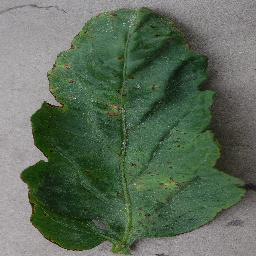

In [8]:
example["image"]

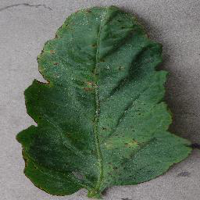

In [9]:
example["image"].resize((200,200))

In [10]:
example["label"]

0

In [11]:
dataset["train"].features["label"]

ClassLabel(names=['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy'], id=None)

In [12]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label
    
id2label[2]

'Tomato___Late_blight'

## Preprocessing the data

In [13]:
from transformers import AutoImageProcessor


image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

2024-01-02 06:42:16.700846: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [14]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean = image_processor.image_mean, std = image_processor.image_std)

In [15]:
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
    
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

In [16]:
train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

In [17]:
# Defining preprocess functions

def preprocess_train(example_batch):
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    
    return example_batch

def preprocess_val(example_batch):
    example_batch["pixel_values"] = [
        val_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batchs

In [18]:
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [19]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [20]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
 'label': 0,
 'pixel_values': tensor([[[-0.3569, -0.3490, -0.3725,  ..., -0.1216, -0.1608, -0.1843],
          [-0.3725, -0.3725, -0.3882,  ..., -0.1216, -0.1529, -0.1843],
          [-0.3804, -0.3882, -0.4039,  ..., -0.1843, -0.1843, -0.1765],
          ...,
          [-0.4353, -0.4275, -0.4275,  ..., -0.0196, -0.0196, -0.0196],
          [-0.4275, -0.4196, -0.4196,  ..., -0.0118, -0.0118, -0.0118],
          [-0.3961, -0.3804, -0.3725,  ..., -0.0039, -0.0039, -0.0039]],
 
         [[-0.3882, -0.3804, -0.4039,  ..., -0.1529, -0.1922, -0.2157],
          [-0.4039, -0.4039, -0.4196,  ..., -0.1529, -0.1843, -0.2157],
          [-0.4118, -0.4196, -0.4353,  ..., -0.2157, -0.2157, -0.2078],
          ...,
          [-0.4431, -0.4353, -0.4353,  ..., -0.0431, -0.0431, -0.0431],
          [-0.4353, -0.4275, -0.4275,  ..., -0.0353, -0.0353, -0.0353],
          [-0.4039, -0.3882, -0.3804,  ..., -0.0275, -0.0275, -0.0275]]

In [21]:
from transformers import ViTForImageClassification, TrainingArguments, Trainer

model = ViTForImageClassification.from_pretrained(
    model_checkpoint,
    label2id = label2id,
    id2label = id2label,
    ignore_mismatched_sizes=True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
pip install accelerate -U

Note: you may need to restart the kernel to use updated packages.


In [23]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-eurosat",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

In [24]:
import numpy as np

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis = 1)
    return metric.compute(predictions = predictions, references=eval_pred.label_ids)

In [25]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values" : pixel_values, "labels": labels}

In [26]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [27]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss,Accuracy
0,0.843000,0.753771,0.946000
2,0.344500,0.317060,0.983000


***** train metrics *****
  epoch                    =         2.98
  total_flos               = 1936605341GF
  train_loss               =       0.8165
  train_runtime            =   4:35:36.03
  train_samples_per_second =        1.633
  train_steps_per_second   =        0.013


In [28]:
metrics = trainer.evaluate()

trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       2.98
  eval_accuracy           =      0.983
  eval_loss               =     0.3171
  eval_runtime            = 0:03:07.39
  eval_samples_per_second =      5.336
  eval_steps_per_second   =      0.171
